# Time Series - TensorFlow
Regional with no series manipulation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../../src'))

from ts import *
from utils import *
from tfts import *

import tensorflow as tf

In [2]:
data_path = "../../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

In [5]:
province = "Lombardia"
compart = "nuovi_positivi"
date = 'data'

In [6]:
df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province].query('20200801 > data')

In [7]:
df = df.set_index(date)

In [8]:
df = df.loc[:, ['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati',
       'isolamento_domiciliare', 'totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'tamponi']]

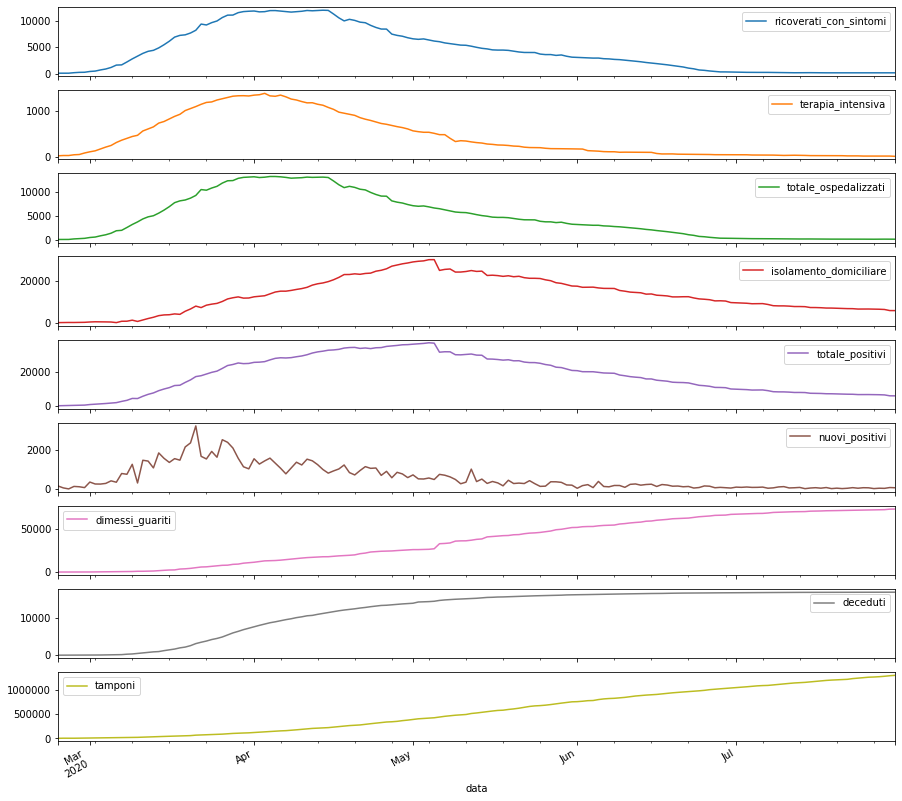

In [9]:
df.plot(subplots=True, figsize=(15,15))
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ricoverati_con_sintomi,159.0,4484.628931,4114.824400,76.0,364.5,3470.0,7336.0,12077.0
terapia_intensiva,159.0,429.742138,453.728676,7.0,47.0,207.0,761.5,1381.0
totale_ospedalizzati,159.0,4914.371069,4550.965845,95.0,412.0,3725.0,8207.0,13328.0
isolamento_domiciliare,159.0,13511.691824,8295.581188,71.0,7162.0,12530.0,20687.0,30382.0
totale_positivi,159.0,18426.062893,11053.013301,166.0,8276.5,17885.0,27935.0,37307.0
nuovi_positivi,159.0,605.113208,635.274793,18.0,113.0,316.0,1022.5,3251.0
dimessi_guariti,159.0,37017.861635,26016.185944,0.0,13131.0,38081.0,62727.5,73402.0
deceduti,159.0,11919.704403,6005.193120,6.0,8483.5,15185.0,16571.5,16806.0
tamponi,159.0,563733.408805,429956.565570,1463.0,138464.0,524163.0,960847.0,1300088.0


In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Single step

In [13]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])
    
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['nuovi_positivi']

In [14]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), 
                          tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}

In [15]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0576 - mean_squared_error: 0.0054


In [16]:
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

### Wide window

In [17]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

wide_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['nuovi_positivi']

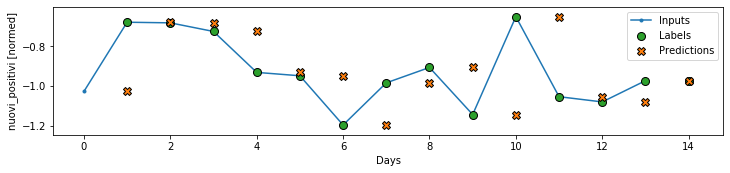

In [18]:
wide_window.plot(baseline, plot_col=compart)

In [19]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [20]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 67ms/step - loss: 4.0814 - mean_absolute_error: 1.7950 - mean_squared_error: 4.0814 - val_loss: 12.2803 - val_mean_absolute_error: 3.4929 - val_mean_squared_error: 12.2803
Epoch 2/50
4/4 [==============================] - 0s 28ms/step - loss: 3.9958 - mean_absolute_error: 1.7761 - mean_squared_error: 3.9958 - val_loss: 11.9686 - val_mean_absolute_error: 3.4483 - val_mean_squared_error: 11.9686
Epoch 3/50
4/4 [==============================] - 0s 23ms/step - loss: 3.9139 - mean_absolute_error: 1.7574 - mean_squared_error: 3.9139 - val_loss: 11.6570 - val_mean_absolute_error: 3.4032 - val_mean_squared_error: 11.6570
Epoch 4/50
4/4 [==============================] - 0s 25ms/step - loss: 3.8306 - mean_absolute_error: 1.7383 - mean_squared_error: 3.8306 - val_loss: 11.3479 - val_mean_absolute_error: 3.3578 - val_mean_squared_error: 11.3479
Epoch 5/50
4/4 [==============================] - 0s 25ms/step - loss: 3.7496 - mean_absolute_error:

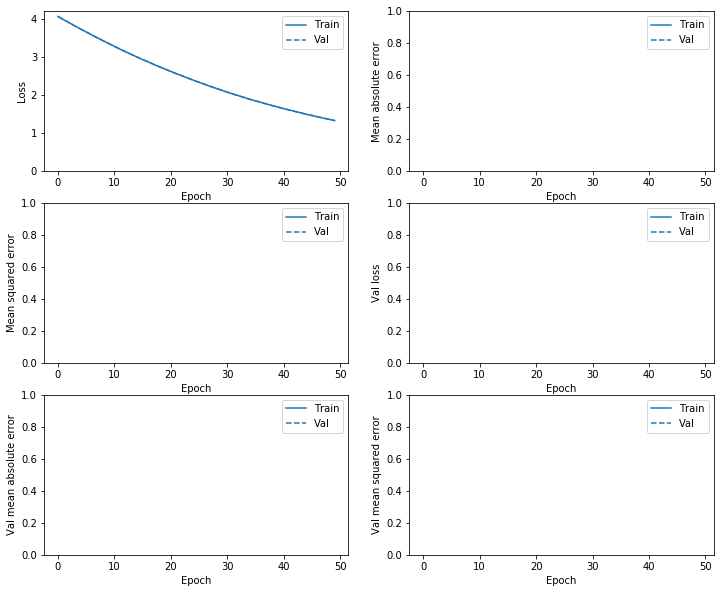

In [21]:
plot_metrics(history)

In [22]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

1/1 [==============================] - 0s 3ms/step - loss: 2.4753 - mean_absolute_error: 1.5691 - mean_squared_error: 2.4753


In [23]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

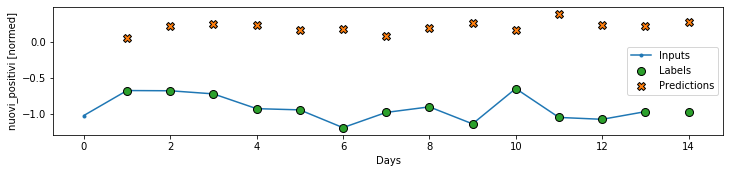

In [24]:
wide_window.plot(linear, plot_col=compart)

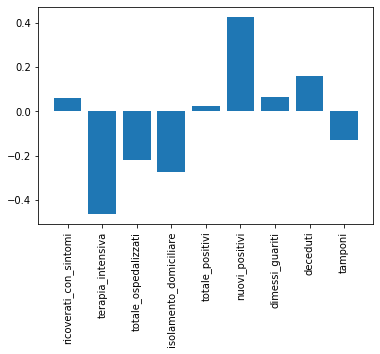

In [25]:
# Show weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [26]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 79ms/step - loss: 1.0997 - mean_absolute_error: 0.8502 - mean_squared_error: 1.0997 - val_loss: 0.3762 - val_mean_absolute_error: 0.6108 - val_mean_squared_error: 0.3762
Epoch 2/50
4/4 [==============================] - 0s 35ms/step - loss: 0.6051 - mean_absolute_error: 0.6074 - mean_squared_error: 0.6051 - val_loss: 0.0508 - val_mean_absolute_error: 0.2171 - val_mean_squared_error: 0.0508
Epoch 3/50
4/4 [==============================] - 0s 24ms/step - loss: 0.3347 - mean_absolute_error: 0.4200 - mean_squared_error: 0.3347 - val_loss: 0.0206 - val_mean_absolute_error: 0.1298 - val_mean_squared_error: 0.0206
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 0.2185 - mean_absolute_error: 0.3260 - mean_squared_error: 0.2185 - val_loss: 0.1615 - val_mean_absolute_error: 0.3916 - val_mean_squared_error: 0.1615
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: 0.1955 - mean_absolute_error: 0.3142 

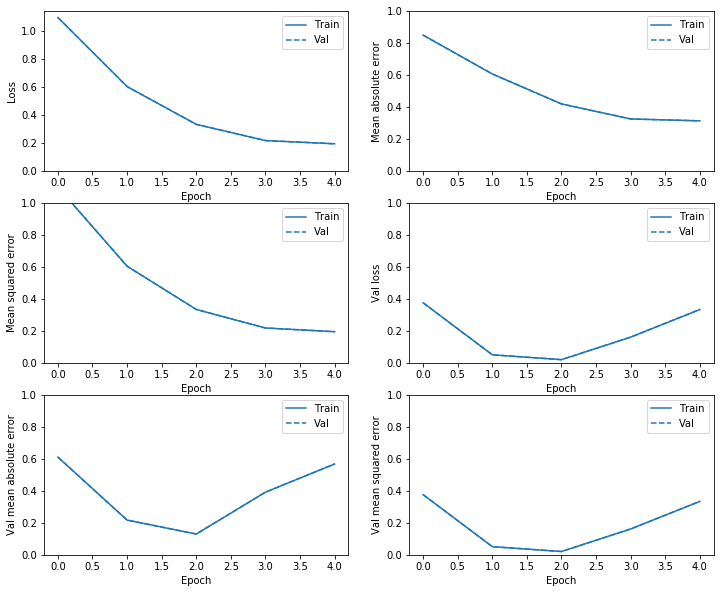

In [27]:
plot_metrics(history)

In [28]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.3341 - mean_absolute_error: 0.5680 - mean_squared_error: 0.3341


In [29]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [30]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['nuovi_positivi']

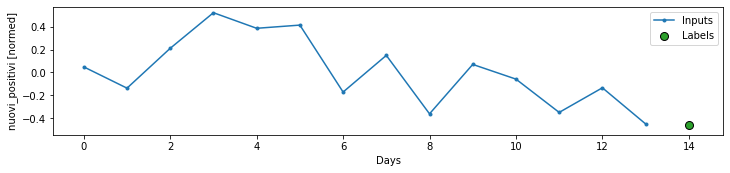

In [31]:
conv_window.plot(plot_col=compart)

In [32]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [33]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/50
4/4 [==============================] - 0s 57ms/step - loss: 0.7045 - mean_absolute_error: 0.7093 - mean_squared_error: 0.7045 - val_loss: 0.5799 - val_mean_absolute_error: 0.7593 - val_mean_squared_error: 0.5799
Epoch 2/50
4/4 [==============================] - 0s 26ms/step - loss: 0.3776 - mean_absolute_error: 0.4849 - mean_squared_error: 0.3776 - val_loss: 0.3072 - val_mean_absolute_error: 0.5520 - val_mean_squared_error: 0.3072
Epoch 3/50
4/4 [==============================] - 0s 25ms/step - loss: 0.2717 - mean_absolute_error: 0.3647 - mean_squared_error: 0.2717 - val_loss: 0.0982 - val_mean_absolute_error: 0.3043 - val_mean_squared_error: 0.0982
Epoch 4/50
4/4 [==============================] - 0s 27ms/step - loss: 0.2357 - mean_absolute_error: 0.3258 - mean_squared_error: 0.2357 - val_loss: 0.0074 - val_mean_absolute_error: 0.0762 - val_mean_squared_error: 0.0074
Epoch 5/50
4/4 [==============================] - 0s 25ms/step - loss: 0.2361 - mean_absolute_error: 0.3471 

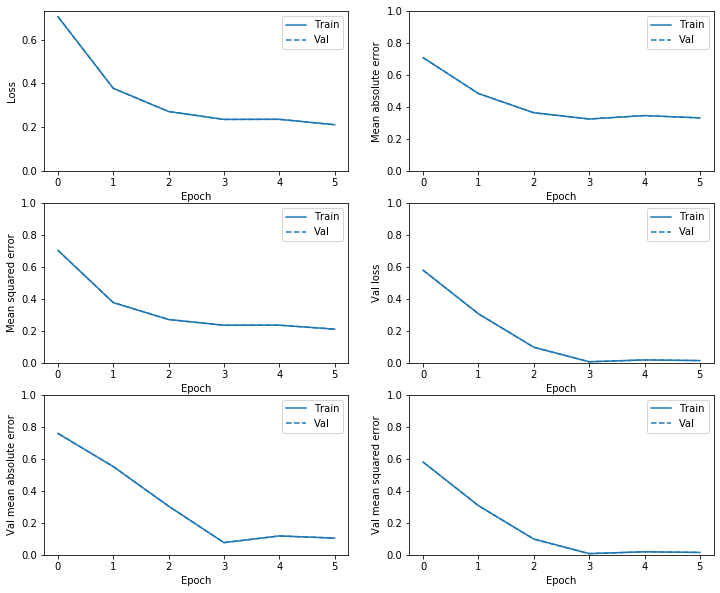

In [34]:
plot_metrics(history)

In [35]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0148 - mean_absolute_error: 0.1044 - mean_squared_error: 0.0148


In [36]:
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

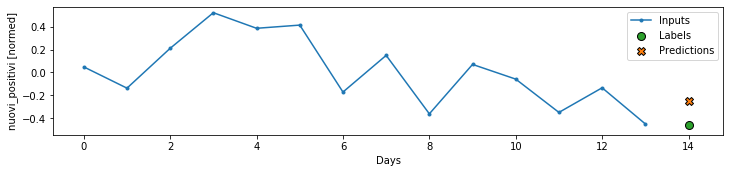

In [37]:
conv_window.plot(multi_step_dense, plot_col=compart)

In [38]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [39]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
4/4 [==============================] - 1s 144ms/step - loss: 0.7032 - mean_absolute_error: 0.6225 - mean_squared_error: 0.7032 - val_loss: 0.4163 - val_mean_absolute_error: 0.6399 - val_mean_squared_error: 0.4163
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 0.5396 - mean_absolute_error: 0.5161 - mean_squared_error: 0.5396 - val_loss: 0.2006 - val_mean_absolute_error: 0.4294 - val_mean_squared_error: 0.2006
Epoch 3/50
4/4 [==============================] - 0s 25ms/step - loss: 0.4430 - mean_absolute_error: 0.4474 - mean_squared_error: 0.4430 - val_loss: 0.0916 - val_mean_absolute_error: 0.2498 - val_mean_squared_error: 0.0916
Epoch 4/50
4/4 [==============================] - 0s 26ms/step - loss: 0.3889 - mean_absolute_error: 0.4195 - mean_squared_error: 0.3889 - val_loss: 0.0591 - val_mean_absolute_error: 0.1597 - val_mean_squared_error: 0.0591
Epoch 5/50
4/4 [==============================] - 0s 25ms/step - loss: 0.3549 - mean_absolute_error: 0.4088

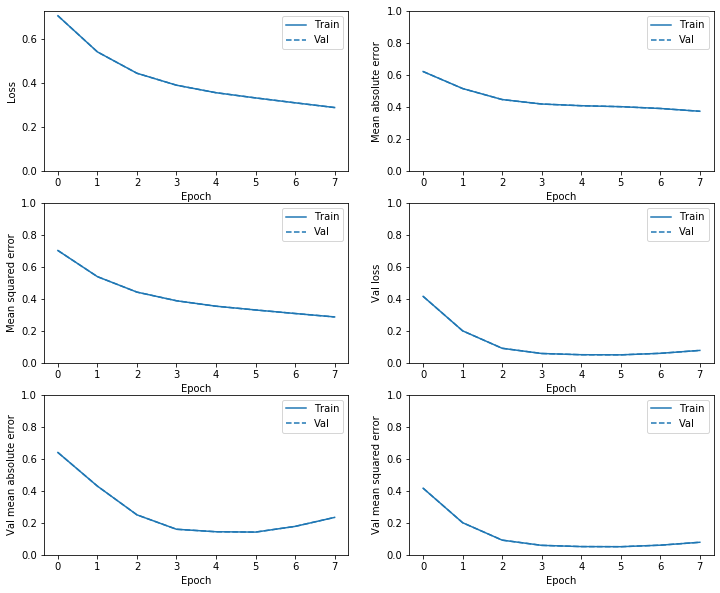

In [40]:
plot_metrics(history)

In [41]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0784 - mean_absolute_error: 0.2339 - mean_squared_error: 0.0784


In [42]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

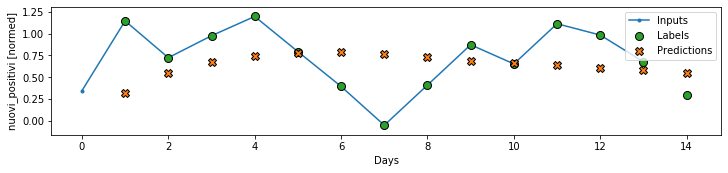

In [43]:
wide_window.plot(lstm_model, plot_col=compart)

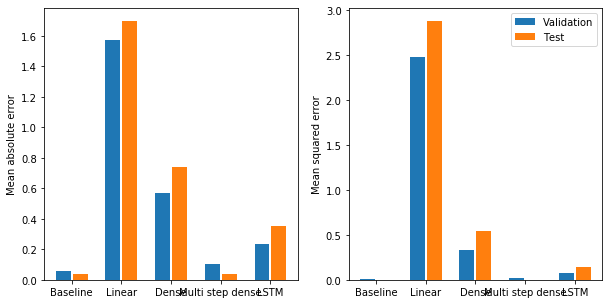

In [44]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

### Multi-output

In [45]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

In [46]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

In [47]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0010


In [48]:
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

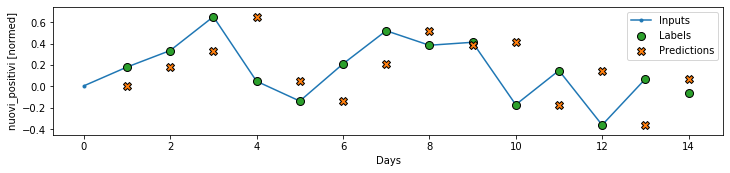

In [49]:
wide_window.plot(baseline, plot_col=compart)

In [50]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [51]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
4/4 [==============================] - 0s 59ms/step - loss: 0.9338 - mean_absolute_error: 0.7872 - mean_squared_error: 0.9338 - val_loss: 1.5646 - val_mean_absolute_error: 0.9959 - val_mean_squared_error: 1.5646
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 0.7503 - mean_absolute_error: 0.7063 - mean_squared_error: 0.7503 - val_loss: 1.3411 - val_mean_absolute_error: 0.9036 - val_mean_squared_error: 1.3411
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6070 - mean_absolute_error: 0.6319 - mean_squared_error: 0.6070 - val_loss: 1.1387 - val_mean_absolute_error: 0.8060 - val_mean_squared_error: 1.1387
Epoch 4/50
4/4 [==============================] - 0s 21ms/step - loss: 0.4944 - mean_absolute_error: 0.5644 - mean_squared_error: 0.4944 - val_loss: 0.9659 - val_mean_absolute_error: 0.7148 - val_mean_squared_error: 0.9659
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 0.3948 - mean_absolute_error: 0.4995 

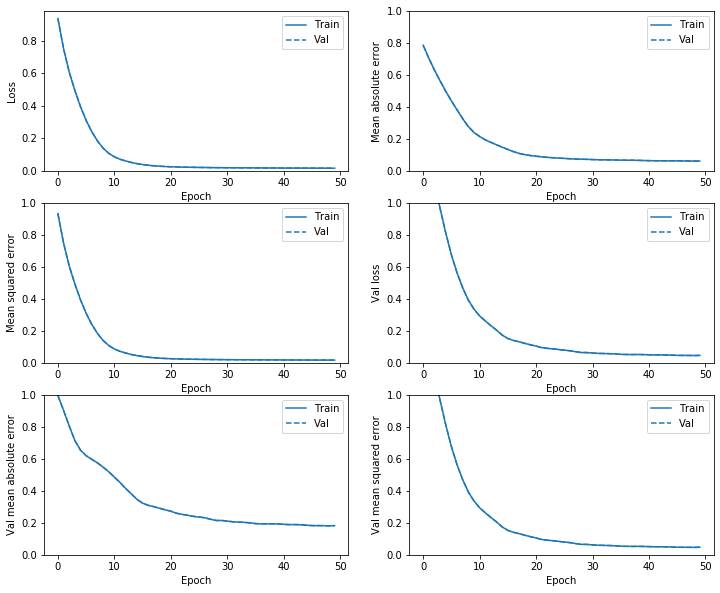

In [52]:
plot_metrics(history)

In [53]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0471 - mean_absolute_error: 0.1824 - mean_squared_error: 0.0471


In [54]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [55]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
4/4 [==============================] - 1s 141ms/step - loss: 0.8860 - mean_absolute_error: 0.8033 - mean_squared_error: 0.8860 - val_loss: 2.6688 - val_mean_absolute_error: 1.5312 - val_mean_squared_error: 2.6688
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 0.7745 - mean_absolute_error: 0.7489 - mean_squared_error: 0.7745 - val_loss: 2.5100 - val_mean_absolute_error: 1.4815 - val_mean_squared_error: 2.5100
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 0.6794 - mean_absolute_error: 0.6985 - mean_squared_error: 0.6794 - val_loss: 2.3434 - val_mean_absolute_error: 1.4276 - val_mean_squared_error: 2.3434
Epoch 4/50
4/4 [==============================] - 0s 26ms/step - loss: 0.5948 - mean_absolute_error: 0.6505 - mean_squared_error: 0.5948 - val_loss: 2.1791 - val_mean_absolute_error: 1.3720 - val_mean_squared_error: 2.1791
Epoch 5/50
4/4 [==============================] - 0s 32ms/step - loss: 0.5211 - mean_absolute_error: 0.6049

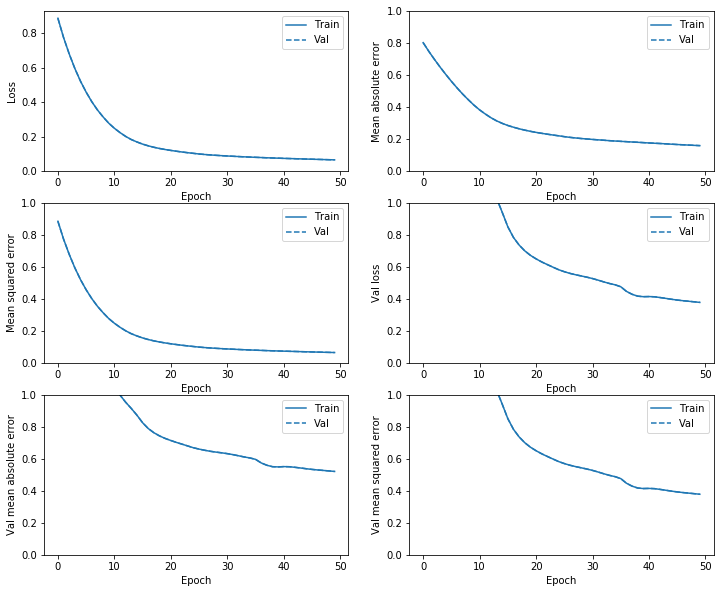

In [56]:
plot_metrics(history)

In [57]:
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.3787 - mean_absolute_error: 0.5214 - mean_squared_error: 0.3787


In [58]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

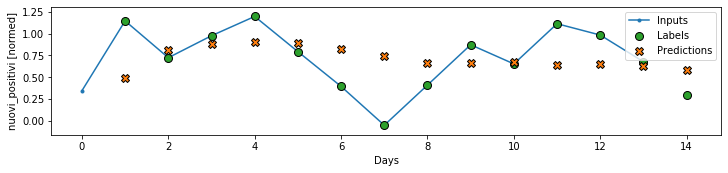

In [59]:
wide_window.plot(lstm_model, plot_col=compart)

In [60]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/50
4/4 [==============================] - 1s 146ms/step - loss: 0.0379 - mean_absolute_error: 0.0833 - mean_squared_error: 0.0379 - val_loss: 0.0011 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0011
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 0.0368 - mean_absolute_error: 0.0764 - mean_squared_error: 0.0368 - val_loss: 0.0012 - val_mean_absolute_error: 0.0258 - val_mean_squared_error: 0.0012
Epoch 3/50
4/4 [==============================] - 0s 25ms/step - loss: 0.0361 - mean_absolute_error: 0.0718 - mean_squared_error: 0.0361 - val_loss: 0.0012 - val_mean_absolute_error: 0.0251 - val_mean_squared_error: 0.0012


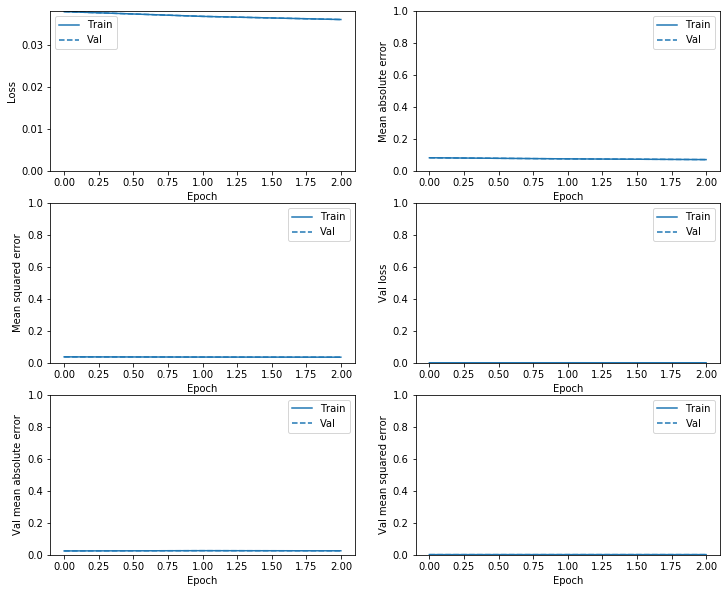

In [61]:
plot_metrics(history)

In [62]:
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0251 - mean_squared_error: 0.0012


In [63]:
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

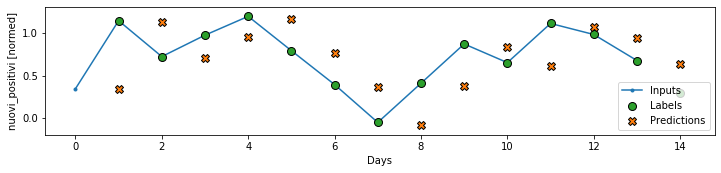

In [64]:
wide_window.plot(residual_lstm, plot_col=compart)

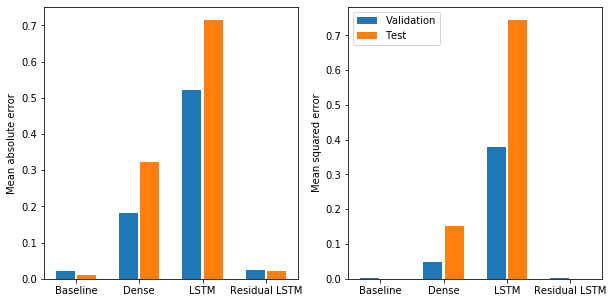

In [65]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

## Multi-step

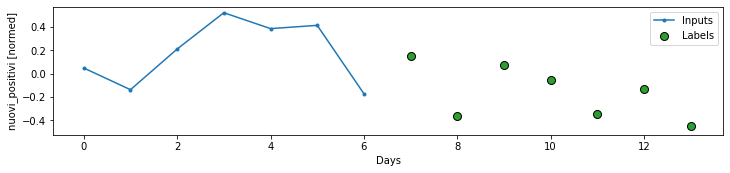

In [66]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
    train_df=train_df, val_df=val_df, test_df=test_df)

multi_window.plot(plot_col=compart)

In [67]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)

In [68]:
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

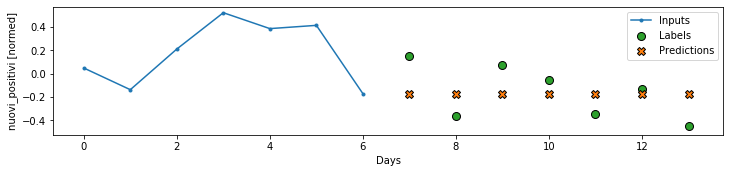

In [69]:
multi_window.plot(last_baseline, plot_col=compart)

In [70]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=0)

In [71]:
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

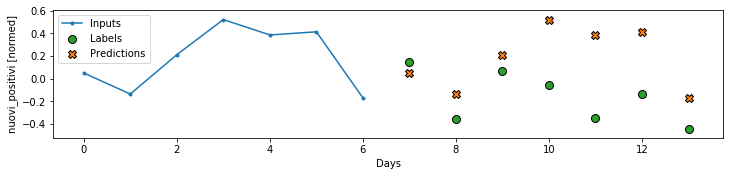

In [72]:
multi_window.plot(repeat_baseline, plot_col=compart)

### Single shot

In [73]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/50
4/4 [==============================] - 0s 58ms/step - loss: 0.8574 - mean_absolute_error: 0.7899 - mean_squared_error: 0.8574 - val_loss: 2.4216 - val_mean_absolute_error: 1.4430 - val_mean_squared_error: 2.4216
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 0.8202 - mean_absolute_error: 0.7712 - mean_squared_error: 0.8202 - val_loss: 2.3294 - val_mean_absolute_error: 1.4155 - val_mean_squared_error: 2.3294
Epoch 3/50
4/4 [==============================] - 0s 31ms/step - loss: 0.7854 - mean_absolute_error: 0.7530 - mean_squared_error: 0.7854 - val_loss: 2.2419 - val_mean_absolute_error: 1.3885 - val_mean_squared_error: 2.2419
Epoch 4/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7527 - mean_absolute_error: 0.7357 - mean_squared_error: 0.7527 - val_loss: 2.1664 - val_mean_absolute_error: 1.3641 - val_mean_squared_error: 2.1664
Epoch 5/50
4/4 [==============================] - 0s 33ms/step - loss: 0.7216 - mean_absolute_error: 0.7191 

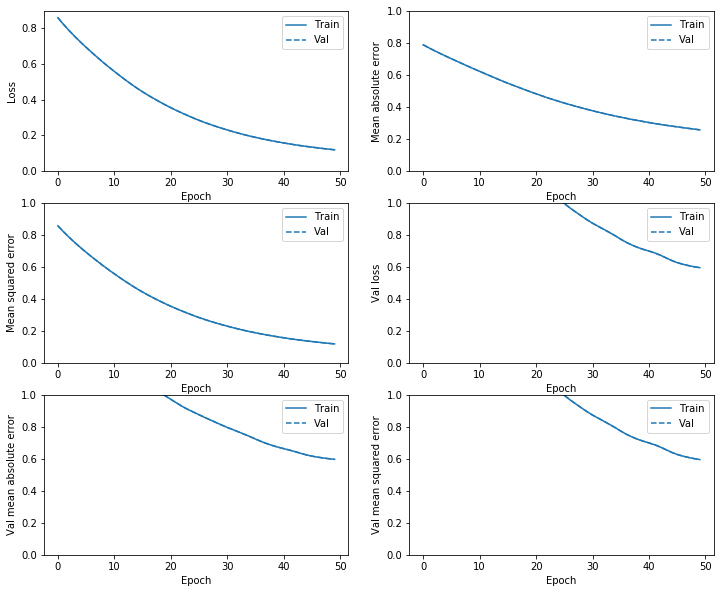

In [74]:
plot_metrics(history)

In [75]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.5958 - mean_absolute_error: 0.5971 - mean_squared_error: 0.5958


In [76]:
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

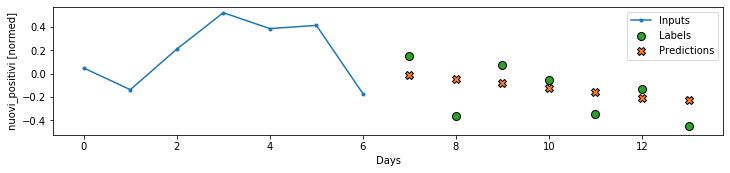

In [77]:
multi_window.plot(multi_linear_model, plot_col=compart)

In [78]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/50
4/4 [==============================] - 0s 74ms/step - loss: 0.8259 - mean_absolute_error: 0.7735 - mean_squared_error: 0.8259 - val_loss: 2.1206 - val_mean_absolute_error: 1.3461 - val_mean_squared_error: 2.1206
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 0.6550 - mean_absolute_error: 0.6813 - mean_squared_error: 0.6550 - val_loss: 1.6924 - val_mean_absolute_error: 1.1941 - val_mean_squared_error: 1.6924
Epoch 3/50
4/4 [==============================] - 0s 22ms/step - loss: 0.4788 - mean_absolute_error: 0.5706 - mean_squared_error: 0.4788 - val_loss: 1.2376 - val_mean_absolute_error: 0.9950 - val_mean_squared_error: 1.2376
Epoch 4/50
4/4 [==============================] - 0s 23ms/step - loss: 0.3126 - mean_absolute_error: 0.4475 - mean_squared_error: 0.3126 - val_loss: 0.8463 - val_mean_absolute_error: 0.7559 - val_mean_squared_error: 0.8463
Epoch 5/50
4/4 [==============================] - 0s 18ms/step - loss: 0.1834 - mean_absolute_error: 0.3284 

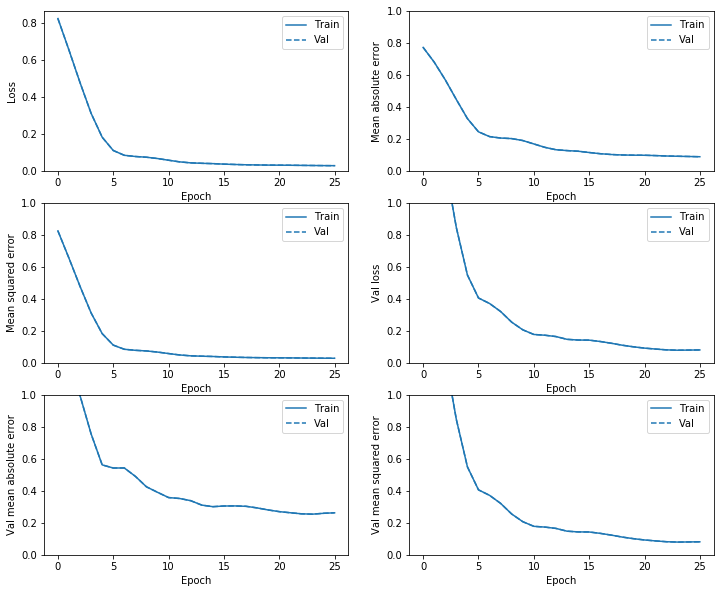

In [79]:
plot_metrics(history)

In [80]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.0813 - mean_absolute_error: 0.2627 - mean_squared_error: 0.0813


In [81]:
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

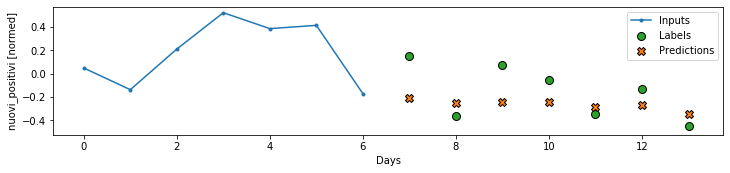

In [82]:
multi_window.plot(multi_dense_model, plot_col=compart)

In [83]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/50
4/4 [==============================] - 1s 125ms/step - loss: 0.8596 - mean_absolute_error: 0.7911 - mean_squared_error: 0.8596 - val_loss: 2.4687 - val_mean_absolute_error: 1.4560 - val_mean_squared_error: 2.4687
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 0.8285 - mean_absolute_error: 0.7755 - mean_squared_error: 0.8285 - val_loss: 2.4075 - val_mean_absolute_error: 1.4376 - val_mean_squared_error: 2.4075
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 0.7925 - mean_absolute_error: 0.7572 - mean_squared_error: 0.7925 - val_loss: 2.3374 - val_mean_absolute_error: 1.4165 - val_mean_squared_error: 2.3374
Epoch 4/50
4/4 [==============================] - 0s 18ms/step - loss: 0.7516 - mean_absolute_error: 0.7355 - mean_squared_error: 0.7516 - val_loss: 2.2519 - val_mean_absolute_error: 1.3904 - val_mean_squared_error: 2.2519
Epoch 5/50
4/4 [==============================] - 0s 20ms/step - loss: 0.7046 - mean_absolute_error: 0.7096

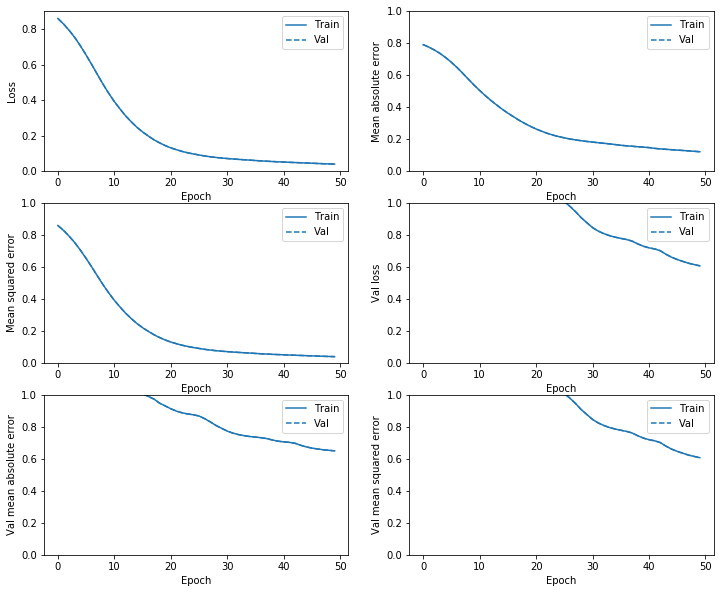

In [84]:
plot_metrics(history)

In [85]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.6073 - mean_absolute_error: 0.6503 - mean_squared_error: 0.6073


In [86]:
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

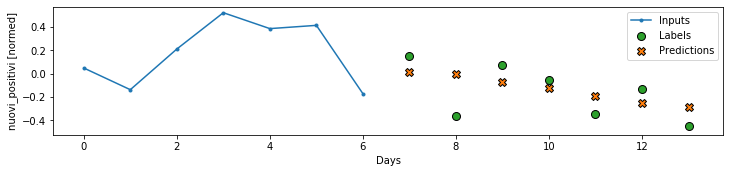

In [87]:
multi_window.plot(multi_lstm_model, plot_col=compart)

## AR model

In [88]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features)

In [89]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

In [90]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/50
4/4 [==============================] - 1s 146ms/step - loss: 0.7726 - mean_absolute_error: 0.7374 - mean_squared_error: 0.7726 - val_loss: 2.3944 - val_mean_absolute_error: 1.4304 - val_mean_squared_error: 2.3944
Epoch 2/50
4/4 [==============================] - 0s 22ms/step - loss: 0.6823 - mean_absolute_error: 0.6889 - mean_squared_error: 0.6823 - val_loss: 2.2353 - val_mean_absolute_error: 1.3831 - val_mean_squared_error: 2.2353
Epoch 3/50
4/4 [==============================] - 0s 24ms/step - loss: 0.6013 - mean_absolute_error: 0.6420 - mean_squared_error: 0.6013 - val_loss: 2.0886 - val_mean_absolute_error: 1.3394 - val_mean_squared_error: 2.0886
Epoch 4/50
4/4 [==============================] - 0s 24ms/step - loss: 0.5265 - mean_absolute_error: 0.5968 - mean_squared_error: 0.5265 - val_loss: 1.9355 - val_mean_absolute_error: 1.2930 - val_mean_squared_error: 1.9355
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: 0.4548 - mean_absolute_error: 0.5500

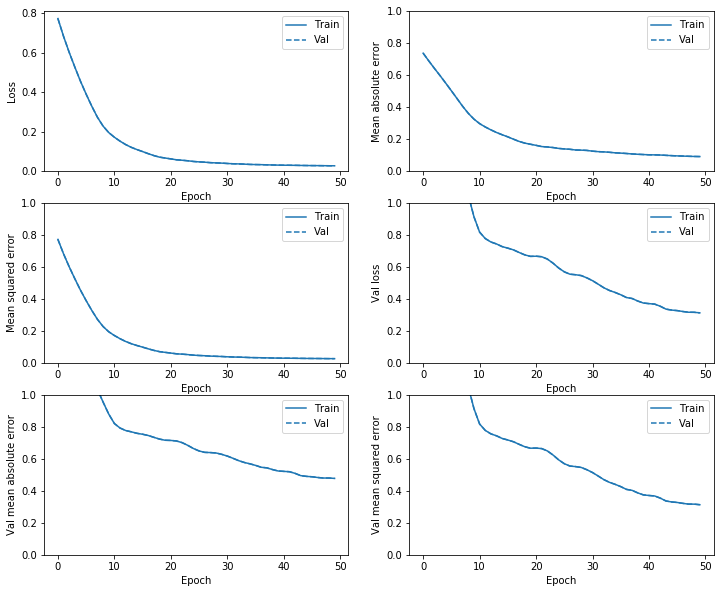

In [91]:
plot_metrics(history)

In [92]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 0.3134 - mean_absolute_error: 0.4778 - mean_squared_error: 0.3134


In [93]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

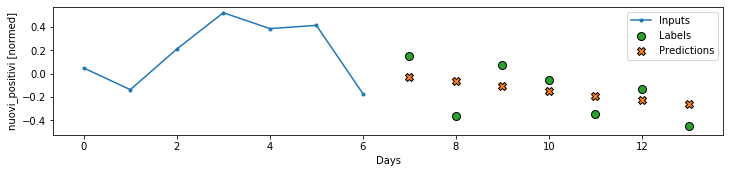

In [94]:
multi_window.plot(feedback_model, plot_col=compart)

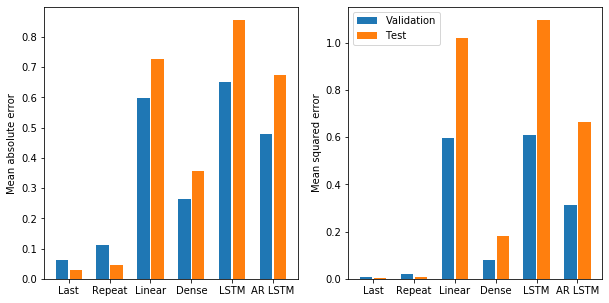

In [95]:
plot_comparison_results(multi_lstm_model.metrics_names, multi_val_performance, multi_performance)